In [1]:
# General tools
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit Functions
from qiskit import  execute,QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
import qiskit.quantum_info as qi

# Tomography functions
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

import warnings 
warnings.filterwarnings('ignore')

### 1
- Make this Quantum Circuit

<div>
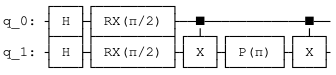
</div>

In [2]:
target = QuantumCircuit(2)


target.h(0)
target.h(1)
target.rx(np.pi/2,0)
target.rx(np.pi/2,1)
target.cx(0,1)
target.p(np.pi,1)
target.cx(0,1)
#target = # YOUR CODE HERE
target_unitary = qi.Operator(target)

# Quantum Process Tomography with Only Shot Noise
Here we will now use the `qasm_simulator` to simulate a Quantum Process Tomography Circuit

###  2a
- Using the Process Tomography Circuits function built into qiskit, create the set of circuits to do quantum process tomography and simulation with a qasm simulator (with shot noise only).

In [3]:

simulator = Aer.get_backend('qasm_simulator')
qpt_circs = process_tomography_circuits(target, measured_qubits=[0,1])
qpt_job = execute(qpt_circs,simulator,seed_simulator=3145,seed_transpiler=3145,shots=8192)
qpt_result = qpt_job.result()

In [4]:
len(qpt_circs)

144

### Question 2b
- Using a least squares fitting method for the Process Tomography Fitter, determin the fidelity of your target unitary


In [5]:

process_results = ProcessTomographyFitter(qpt_result, qpt_circs)  
choi_matrix = process_results.fit(method = 'lstsq') 
fidelity = qi.average_gate_fidelity(choi_matrix,target_unitary )
fidelity

0.9926697818280223

# Quantum Process Tomography with a T1/T2 Noise Model
For the sake of consistency, let's set some values to characterize the duration of our gates and T1/T2 times:

In [6]:
# T1 and T2 values for qubits 0-3
T1s = [15000, 19000, 22000, 14000]
T2s = [30000, 25000, 18000, 28000]

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

In [7]:
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

### 3)
- Using the Thermal Relaxation Error model built into qiskit, define `u1`,`u2`,`u3`, `cx`, `measurement` and `reset` errors usi

In [8]:
# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()


for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], 'reset', [j])
    noise_thermal.add_quantum_error(errors_measure[j], 'measure', [j])
    noise_thermal.add_quantum_error(errors_u1[j], 'u1', [j])
    noise_thermal.add_quantum_error(errors_u2[j], 'u2', [j])
    noise_thermal.add_quantum_error(errors_u3[j], 'u3', [j])

    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], 'cx', [j,k])


### 4)
- Get a QPT fidelity using the noise model,but without using any error mitigation techniques.  Again, use `seed_simulator=3145`, `seed_transpiler=3145` and `shots=8192` for the `execute` function





In [9]:
np.random.seed(0)

# YOUR CODE HERE

    
simulator = Aer.get_backend('qasm_simulator')

qpt_job = execute(qpt_circs,simulator, seed_simulator=3145, seed_transpiler=3145, shots=8192,noise_model=noise_thermal)
qpt_result = qpt_job.result()



mit_noisy_qpt_tono = ProcessTomographyFitter(qpt_result,qpt_circs)
mit_noisy_qpt_lstsq = mit_noisy_qpt_tono.fit(method='lstsq')
fidelity = qi.average_gate_fidelity(mit_noisy_qpt_lstsq , target)


In [10]:
np.random.seed(0)


simulator = Aer.get_backend('qasm_simulator')
meas_cal_circs, state_labels= complete_meas_cal(qubit_list=[0,1])
meas_cal_job = execute(meas_cal_circs,simulator, seed_simulator=3145, seed_transpiler=3145, shots=8192,noise_model=noise_thermal)
meas_cal_result = meas_cal_job.result()

meas_fitter = CompleteMeasFitter(meas_cal_result,state_labels)
meas_filter = meas_fitter.filter

mit_noisy_qpt_result = meas_filter.apply(qpt_result)
mit_noisy_qpt_tono = ProcessTomographyFitter(mit_noisy_qpt_result,qpt_circs)
mit_noisy_qpt_lstsq = mit_noisy_qpt_tono.fit(method='lstsq')
fidelity = qi.average_gate_fidelity(mit_noisy_qpt_lstsq , target_unitary)
print(fidelity)

0.959927748985467
